# notebook setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import copy
import utils
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report

# data preprocessing

## feature data

In [ ]:
features_data = utils.load("fma_metadata/features.csv")

In [ ]:
features_data.columns, features_data.shape

(MultiIndex([('chroma_cens', 'kurtosis', '01'),
             ('chroma_cens', 'kurtosis', '02'),
             ('chroma_cens', 'kurtosis', '03'),
             ('chroma_cens', 'kurtosis', '04'),
             ('chroma_cens', 'kurtosis', '05'),
             ('chroma_cens', 'kurtosis', '06'),
             ('chroma_cens', 'kurtosis', '07'),
             ('chroma_cens', 'kurtosis', '08'),
             ('chroma_cens', 'kurtosis', '09'),
             ('chroma_cens', 'kurtosis', '10'),
             ...
             (    'tonnetz',      'std', '04'),
             (    'tonnetz',      'std', '05'),
             (    'tonnetz',      'std', '06'),
             (        'zcr', 'kurtosis', '01'),
             (        'zcr',      'max', '01'),
             (        'zcr',     'mean', '01'),
             (        'zcr',   'median', '01'),
             (        'zcr',      'min', '01'),
             (        'zcr',     'skew', '01'),
             (        'zcr',      'std', '01')],
            names=['fe

In [ ]:
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features_data[column].head().style.format('{:.2f}'))

In [ ]:
# flatten the dataframe
features_data.columns = [' '.join(col) for col in features_data.columns]
features_data = features_data.reset_index()
features_data.head()

,track_id,chroma_cens kurtosis 01,chroma_cens kurtosis 02,chroma_cens kurtosis 03,chroma_cens kurtosis 04,chroma_cens kurtosis 05,chroma_cens kurtosis 06,chroma_cens kurtosis 07,chroma_cens kurtosis 08,chroma_cens kurtosis 09,...,tonnetz std 04,tonnetz std 05,tonnetz std 06,zcr kurtosis 01,zcr max 01,zcr mean 01,zcr median 01,zcr min 01,zcr skew 01,zcr std 01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


## track data

In [ ]:
tracks = utils.load('fma_metadata/tracks.csv')

In [ ]:
tracks.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [ ]:
## using genre_top as target label
tracks["track", "genre_top"], tracks["track", "genre_top"].shape

(track_id
 2         Hip-Hop
 3         Hip-Hop
 5         Hip-Hop
 10            Pop
 20            NaN
            ...   
 155316       Rock
 155317       Rock
 155318       Rock
 155319       Rock
 155320        NaN
 Name: (track, genre_top), Length: 106574, dtype: category
 Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken'],
 (106574,))

In [ ]:
# drop tracks with no genre_top
label = tracks["track", "genre_top"].dropna().reset_index()
label.columns = [''.join(col) for col in label.columns]
label = label.rename(columns={"trackgenre_top" : "genre"})
label.shape, label

((49598, 2),
        track_id    genre
 0             2  Hip-Hop
 1             3  Hip-Hop
 2             5  Hip-Hop
 3            10      Pop
 4           134  Hip-Hop
 ...         ...      ...
 49593    155315     Rock
 49594    155316     Rock
 49595    155317     Rock
 49596    155318     Rock
 49597    155319     Rock
 
 [49598 rows x 2 columns])

In [ ]:
features_data = features_data.merge(label, how="inner", on="track_id")
features_data = features_data.drop(columns="track_id")
features_data

,chroma_cens kurtosis 01,chroma_cens kurtosis 02,chroma_cens kurtosis 03,chroma_cens kurtosis 04,chroma_cens kurtosis 05,chroma_cens kurtosis 06,chroma_cens kurtosis 07,chroma_cens kurtosis 08,chroma_cens kurtosis 09,chroma_cens kurtosis 10,...,tonnetz std 05,tonnetz std 06,zcr kurtosis 01,zcr max 01,zcr mean 01,zcr median 01,zcr min 01,zcr skew 01,zcr std 01,genre
0,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,Hip-Hop
1,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,Hip-Hop
2,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,Hip-Hop
3,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,Pop
4,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.000000,1.806106,0.054623,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49593,-0.319850,0.653044,1.300360,-0.606061,-1.109302,-1.006683,0.059643,0.472580,-0.856436,-0.524676,...,0.016631,0.014705,6.947788,0.188477,0.037708,0.035156,0.002930,1.764233,0.018679,Rock
49594,-0.490129,0.463834,2.321970,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,1.951819,...,0.022547,0.019816,4.448255,0.172852,0.028773,0.028320,0.003906,0.955388,0.012385,Rock
49595,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,-0.492753,...,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.283060,0.019059,Rock
49596,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.713526,1.418444,1.325197,0.120333,...,0.017540,0.020471,2.356727,0.212891,0.038450,0.037109,0.003418,0.828569,0.017904,Rock


# Random Forest

In [ ]:
# split data into training and test
y = features_data["genre"].copy(deep=True)
X = features_data.drop(columns="genre").copy(deep=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37198, 518), (37198,), (12400, 518), (12400,))

## preliminary result

In [ ]:
# classifier fitting
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# classifier testing
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.625

In [ ]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## search for best model

In [ ]:
## set up random search grid
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   0.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 4.1min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 4.1min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time= 4.1min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=160

/opt/homebrew/anaconda3/envs/MLproject/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=10.3min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1600; total time=10.3min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=12.1min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=12.1min
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=12.1min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=13.0min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.1s
[CV] END bootstrap=False, max_depth=5

Bad pipe message: %s [b'\x16;?\x1f:\xb9\xa3\xd012l\x91]\xd5+\xcb\xfc\x1e\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i']
Bad pipe message: %s [b'vm\xbb\xfer\xfd\x9d\x93\x12\xe8\x8d\x8c\xe7\nV\xb3\xd7F\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00']
Bad pipe message: %s [b'\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x00']
Bad pipe message: %s [b'p\xaf\x8d\xd3\x90B\xd0\xc0l>\xbd\x0c\xd1\xbbg\xea\xc2x\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x0

[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=153.9min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=153.9min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2000; total time=153.9min


/opt/homebrew/anaconda3/envs/MLproject/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/MLproject/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/anaconda3/envs/MLproject/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/homebrew/anaconda3/envs/MLproject/lib/python3.12/site-packages/sklearn/base.py", line 666, in _v

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

<Figure size 640x480 with 0 Axes>

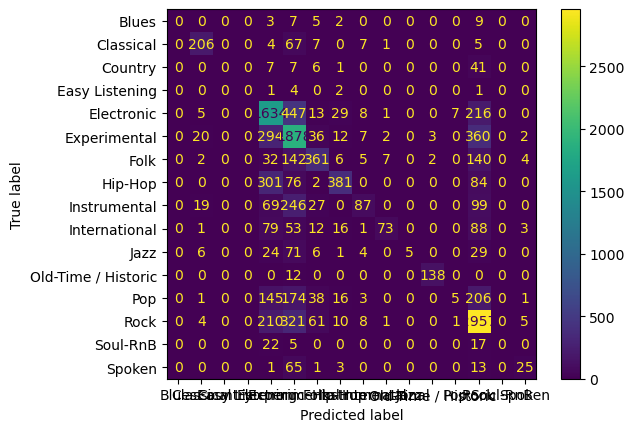

<Figure size 640x480 with 0 Axes>

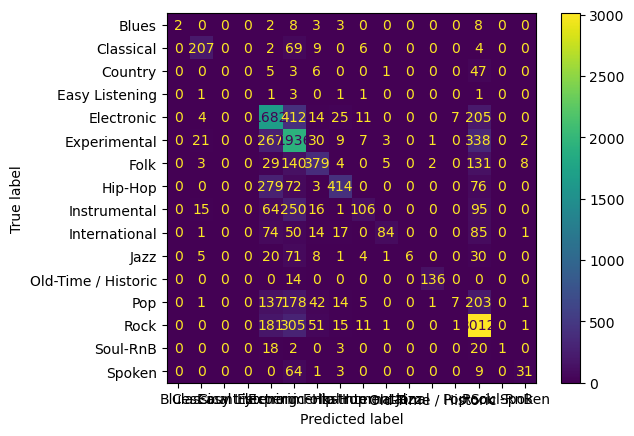

In [ ]:
## compare base vs best model
best_model = rf_random.best_estimator_
base_model = clf

plt.figure()
base_pred = base_model.predict(X_test)
cm_base = confusion_matrix(y_test, base_pred, labels=base_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base,
                              display_labels=base_model.classes_)
disp.plot()
plt.show()

plt.figure()
best_pred = best_model.predict(X_test)
cm_best = confusion_matrix(y_test, best_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best,
                              display_labels=best_model.classes_)
disp.plot()
plt.show()

In [ ]:
accuracy_score(y_test, best_pred)

0.6454032258064516

In [ ]:
accuracy_score(y_test, base_pred)

0.625